In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicular-movements-datasets/vehicle path (Day).csv
/kaggle/input/vehicular-movements-datasets/geo1.csv


In [2]:
import pandas as pd

# Load the datasets
vehicle_data = pd.read_csv("/kaggle/input/vehicular-movements-datasets/vehicle path (Day).csv")
geo_data = pd.read_csv("/kaggle/input/vehicular-movements-datasets/geo1.csv")

# Display the first few rows of each dataset to understand their structure
print("Vehicle Path Data:")
print(vehicle_data.head())

print("\nGeo1 Data:")
print(geo_data.head())

# Display basic info and statistics
print("\nVehicle Path Data Info:")
print(vehicle_data.info())

print("\nGeo1 Data Info:")
print(geo_data.info())

print("\nVehicle Path Data Statistics:")
print(vehicle_data.describe())

print("\nGeo1 Data Statistics:")
print(geo_data.describe())


Vehicle Path Data:
   Unnamed: 0  timestep_time vehicle_type  vehicle_y  vehicle_x  \
0           0            0.0          Bus     555.85    1588.94   
1           1            0.0          Bus     722.81    1270.66   
2           2            0.0          Bus     471.48    1183.77   
3           3            0.0          Bus     711.28     874.23   
4           4            0.0      Vehicle     517.45    1849.76   

   vehicle_speed                vehicle_id  
0            0.0        BusFlowEastWest0.0  
1            0.0      BusFlowNorthSouth0.0  
2            0.0      BusFlowSouthNorth0.0  
3            0.0        BusFlowWestEast0.0  
4            0.0  VehicleFlowEastToNorth.0  

Geo1 Data:
   Unnamed: 0                                   ADDRESS   LATITUDE  LONGITUDE
0           1  W MARTIN LUTHER KING JR BLVD / NUECES ST  30.282237 -97.743748
1           2                       MANOR RD / ROGGE LN  30.304550 -97.681317
2           3                     WHELESS LN / LINDA LN  30.31

In [3]:
# Check for missing values
print("\nMissing values in Vehicle Path Data:")
print(vehicle_data.isnull().sum())

print("\nMissing values in Geo1 Data:")
print(geo_data.isnull().sum())

# Drop or fill missing values as needed
vehicle_data = vehicle_data.dropna()  # or fillna() depending on the dataset characteristics
geo_data = geo_data.dropna()  # or fillna()

# Ensure correct data types
vehicle_data['timestep_time'] = pd.to_datetime(vehicle_data['timestep_time'])
# Similarly, convert other columns to their appropriate types if necessary

# Preview the cleaned data
print("\nCleaned Vehicle Path Data:")
print(vehicle_data.head())

print("\nCleaned Geo1 Data:")
print(geo_data.head())



Missing values in Vehicle Path Data:
Unnamed: 0       0
timestep_time    0
vehicle_type     0
vehicle_y        0
vehicle_x        0
vehicle_speed    0
vehicle_id       0
dtype: int64

Missing values in Geo1 Data:
Unnamed: 0    0
ADDRESS       0
LATITUDE      0
LONGITUDE     0
dtype: int64

Cleaned Vehicle Path Data:
   Unnamed: 0 timestep_time vehicle_type  vehicle_y  vehicle_x  vehicle_speed  \
0           0    1970-01-01          Bus     555.85    1588.94            0.0   
1           1    1970-01-01          Bus     722.81    1270.66            0.0   
2           2    1970-01-01          Bus     471.48    1183.77            0.0   
3           3    1970-01-01          Bus     711.28     874.23            0.0   
4           4    1970-01-01      Vehicle     517.45    1849.76            0.0   

                 vehicle_id  
0        BusFlowEastWest0.0  
1      BusFlowNorthSouth0.0  
2      BusFlowSouthNorth0.0  
3        BusFlowWestEast0.0  
4  VehicleFlowEastToNorth.0  

Cleaned Geo1 

In [4]:
from pyproj import Transformer

# Initialize the Transformer for UTM Zone 14N to WGS84 (latitude/longitude)
transformer = Transformer.from_crs("epsg:32614", "epsg:4326", always_xy=True)

# Function to convert x-y to lat-long using the new Transformer class
def convert_xy_to_latlong(x, y):
    longitude, latitude = transformer.transform(x, y)
    return latitude, longitude

# Apply the conversion to the vehicle data
vehicle_data['latitude'], vehicle_data['longitude'] = zip(*vehicle_data.apply(
    lambda row: convert_xy_to_latlong(row['vehicle_x'], row['vehicle_y']), axis=1))

# Display the updated vehicle data with lat-long
print(vehicle_data[['vehicle_x', 'vehicle_y', 'latitude', 'longitude']].head())


   vehicle_x  vehicle_y  latitude   longitude
0    1588.94     555.85  0.005014 -103.474508
1    1270.66     722.81  0.006519 -103.477360
2    1183.77     471.48  0.004253 -103.478138
3     874.23     711.28  0.006415 -103.480912
4    1849.76     517.45  0.004667 -103.472172


In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Extract geo_data latitudes and longitudes
geo_coords = geo_data[['LATITUDE', 'LONGITUDE']].values

# Initialize NearestNeighbors with 1 neighbor (closest point)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(geo_coords)

# Function to find the nearest road point
def find_nearest_road(lat, lon):
    vehicle_coord = np.array([[lat, lon]])
    distances, indices = nbrs.kneighbors(vehicle_coord)
    nearest_index = indices[0][0]
    return geo_data.iloc[nearest_index]['ADDRESS'], geo_data.iloc[nearest_index]['LATITUDE'], geo_data.iloc[nearest_index]['LONGITUDE']

# Apply map-matching to vehicle data
vehicle_data['nearest_road'], vehicle_data['road_lat'], vehicle_data['road_lon'] = zip(
    *vehicle_data.apply(lambda row: find_nearest_road(row['latitude'], row['longitude']), axis=1))

# Show the map-matched results
print(vehicle_data[['latitude', 'longitude', 'nearest_road', 'road_lat', 'road_lon']].head())


   latitude   longitude nearest_road  road_lat    road_lon
0  0.005014 -103.474508    E 51ST ST  3.442387 -105.983195
1  0.006519 -103.477360    E 51ST ST  3.442387 -105.983195
2  0.004253 -103.478138    E 51ST ST  3.442387 -105.983195
3  0.006415 -103.480912    E 51ST ST  3.442387 -105.983195
4  0.004667 -103.472172    E 51ST ST  3.442387 -105.983195


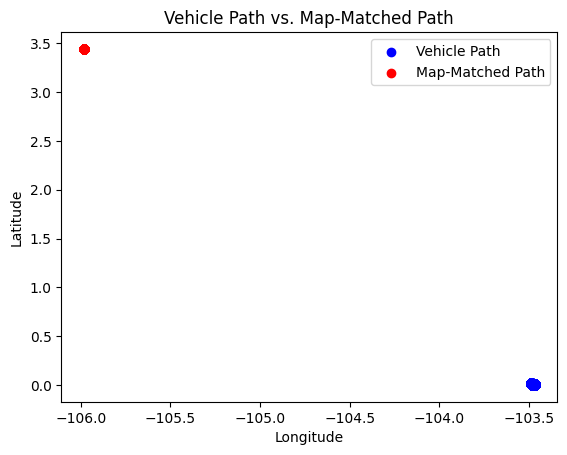

In [8]:
import matplotlib.pyplot as plt

# Plot original vehicle paths (before matching)
plt.scatter(vehicle_data['longitude'], vehicle_data['latitude'], color='blue', label='Vehicle Path')

# Plot map-matched paths
plt.scatter(vehicle_data['road_lon'], vehicle_data['road_lat'], color='red', label='Map-Matched Path')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vehicle Path vs. Map-Matched Path')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

# data = pd.read_csv("/kaggle/input/vehicular-movements-datasets/vehicle path (Day).csv")
data = vehicle_data
data = pd.get_dummies(data)
print(data)

# data = data.drop(column =['Vehicle'])
data['random_label'] = np.random.randint(0, 2, data.shape[0])

print(data['random_label'])
x = data.drop(columns = ['random_label'])
print(x)
y = data['random_label']
print(y)

x_train, x_test,y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


print(x_train)
print(x_test)
print(y_train)
print(y_test)

model = Sequential()
model.add(Dense(30, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=500, batch_size=10, validation_split=0.2)
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

        Unnamed: 0                 timestep_time  vehicle_y  vehicle_x  \
0                0 1970-01-01 00:00:00.000000000     555.85    1588.94   
1                1 1970-01-01 00:00:00.000000000     722.81    1270.66   
2                2 1970-01-01 00:00:00.000000000     471.48    1183.77   
3                3 1970-01-01 00:00:00.000000000     711.28     874.23   
4                4 1970-01-01 00:00:00.000000000     517.45    1849.76   
...            ...                           ...        ...        ...   
962714      962714 1970-01-01 00:00:00.000007380     663.90    2249.32   
962715      962715 1970-01-01 00:00:00.000007380     684.13    2279.96   
962716      962716 1970-01-01 00:00:00.000007381     671.42    2260.76   
962717      962717 1970-01-01 00:00:00.000007382     678.62    2271.64   
962718      962718 1970-01-01 00:00:00.000007383     685.81    2282.50   

        vehicle_speed  latitude   longitude  road_lat    road_lon  \
0                0.00  0.005014 -103.47450

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

# Load dataset
data = vehicle_data

# Create a random label for classification (binary classification example)
data['random_label'] = np.random.randint(0, 2, data.shape[0])

# Define features (X) and target (y)
x = data.drop(columns=['random_label'])  # Input features
y = data['random_label']  # Target label (random binary label)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Build the neural network model
model = Sequential()
model.add(Dense(30, input_dim=x_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(30, activation='relu'))  # Hidden layer 1
model.add(Dense(30, activation='relu'))  # Hidden layer 2
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model with appropriate loss function and optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

NameError: name 'vehicle_data' is not defined